# Project: European Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> In this project we will try to wrangle and analyze the European Soccer Database from season 2008 to season 2016. The data source for this project is a SQLite Database that can be found on <a href="https://www.kaggle.com/hugomathien/soccer">Kaggle</a>. This Database contains data for:
>
>> - +25,000 matches.
>>
>> - +10,000 players.
>>
>> - 11 European Countries with their lead championship.
>>
>> - Seasons 2008 to 2016.
>>
>> - Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates.
>>
>> - Team line up with squad formation (X, Y coordinates).
>>
>> - Betting odds from up to 10 providers.
>>
>> - Detailed match events (goal types, possession, corner, cross, fouls, cards etc…) for +10,000 matches.
>
>  The Database contains 7 tables. I will only focus on 2 tables which are 'Player' and 'Player_Attributes' and try to find answer for the following questions:
>
>> What is the relationship between the player's age and his aggression level?
>>
>> What is the relationship between player's BMI(mass(KG)/height^2(M^2)) and shot power?
>>
>> what is the relationship between player's age and his finishing?
>>
>> who was the best under 18 player in this period(based on the overall rating)?
>>
>> what is the average BMI of a soccer player in the period?
>>
>> who was the tallest player played in this period?
>>
>> who is the player who had the most penalties?
>

In [160]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### Gather

In [161]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("database.sqlite")
df_player = pd.read_sql_query("SELECT * from Player", con)
df_player_att = pd.read_sql_query("SELECT * from Player_Attributes", con)
con.close()

### Assess

In [162]:
df_player.columns

Index(['id', 'player_api_id', 'player_name', 'player_fifa_api_id', 'birthday',
       'height', 'weight'],
      dtype='object')

In [163]:
df_player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  11060 non-null  int64  
 1   player_api_id       11060 non-null  int64  
 2   player_name         11060 non-null  object 
 3   player_fifa_api_id  11060 non-null  int64  
 4   birthday            11060 non-null  object 
 5   height              11060 non-null  float64
 6   weight              11060 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 605.0+ KB


- birthday is object
- weight is int not float

In [164]:
df_player['height'].sample()

444    177.8
Name: height, dtype: float64

- height in cm not meters.

In [165]:
df_player['weight'].sample()

2193    181
Name: weight, dtype: int64

- weight in Ibs not Kgs

In [166]:
df_player_att.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

- no need for these columns in our analysis ['potential', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate', 'crossing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'jumping', 'stamina', 'strength', 'long_shots', 'interceptions', 'positioning', 'vision', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']

In [167]:
columns = ['potential', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate', 'crossing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'jumping', 'stamina', 'strength', 'long_shots', 'interceptions', 'positioning', 'vision', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']
df_player_att.drop(columns=columns, inplace=True)
df_player_att.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'finishing', 'shot_power', 'aggression', 'penalties'],
      dtype='object')

In [168]:
df_player_att.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  183978 non-null  int64  
 1   player_fifa_api_id  183978 non-null  int64  
 2   player_api_id       183978 non-null  int64  
 3   date                183978 non-null  object 
 4   overall_rating      183142 non-null  float64
 5   finishing           183142 non-null  float64
 6   shot_power          183142 non-null  float64
 7   aggression          183142 non-null  float64
 8   penalties           183142 non-null  float64
dtypes: float64(5), int64(3), object(1)
memory usage: 12.6+ MB


- date is object
- missing values in all stats of players('overall_rating', 'finishing',..)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016595EC33D0>,
      dtype=object)

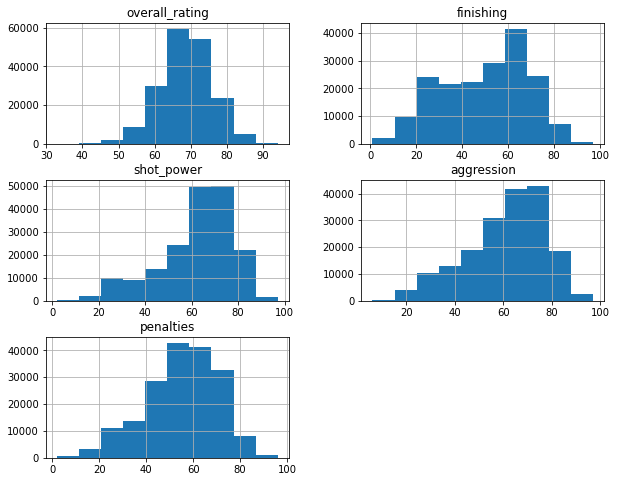

In [169]:
df_player_att[['overall_rating', 'finishing', 'shot_power', 'aggression', 'penalties']].hist(figsize=(10, 8))

In [170]:
df_player_att.describe()

,id,player_fifa_api_id,player_api_id,overall_rating,finishing,shot_power,aggression,penalties
count,183978.00000,183978.000000,183978.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000
mean,91989.50000,165671.524291,135900.617324,68.600015,49.921078,61.808427,60.948046,55.003986
std,53110.01825,53851.094769,136927.840510,7.041139,19.038705,16.135143,16.089521,15.546519
min,1.00000,2.000000,2625.000000,33.000000,1.000000,2.000000,6.000000,2.000000
25%,45995.25000,155798.000000,34763.000000,64.000000,34.000000,54.000000,51.000000,45.000000
50%,91989.50000,183488.000000,77741.000000,69.000000,53.000000,65.000000,64.000000,57.000000
75%,137983.75000,199848.000000,191080.000000,73.000000,65.000000,73.000000,73.000000,67.000000
max,183978.00000,234141.000000,750584.000000,94.000000,97.000000,97.000000,97.000000,96.000000


#### Assessment results
- in 'df_player':
    - birthday is object -done
    - weight is int not float -done
    - height in cm not meters -done
    - weight in Ibs not Kgs -done
- in 'df_player_att':
    - date is object - done
    - missing values in all stats of players('overall_rating', 'finishing',..) - done
- 'df_player' and 'df_player_att' are one observational unit - done



### Clean

In [171]:
# merge the 2 dataset into one 'players' dataset
df_players = pd.merge(df_player, df_player_att, on='player_api_id', how='right')
df_players.drop(columns=['id_x', 'id_y', 'player_fifa_api_id_x', 'player_fifa_api_id_y'], inplace=True)
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183978 entries, 0 to 183977
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   player_api_id   183978 non-null  int64  
 1   player_name     183978 non-null  object 
 2   birthday        183978 non-null  object 
 3   height          183978 non-null  float64
 4   weight          183978 non-null  int64  
 5   date            183978 non-null  object 
 6   overall_rating  183142 non-null  float64
 7   finishing       183142 non-null  float64
 8   shot_power      183142 non-null  float64
 9   aggression      183142 non-null  float64
 10  penalties       183142 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 16.8+ MB


In [172]:
# change birthday and date to datetime objects
df_players['birthday'] = pd.to_datetime(df_players['birthday'])
df_players['date'] = pd.to_datetime(df_players['date'])


In [173]:
# add player's age row as a difference between date and birthday
df_players['age'] = (df_players['date'] - df_players['birthday']).dt.days/365
df_players['age'] = df_players['age'].astype(int)
df_players['age'].value_counts()

24    14403
25    14372
26    14274
23    14129
27    13557
22    13439
21    12447
28    11929
20    10734
29    10388
30     8784
19     8447
31     7314
32     6044
18     5024
33     4752
34     3466
35     2163
17     2075
36     1166
16      731
15      725
37      703
14      594
13      534
12      425
38      358
11      304
10      211
39      208
40       93
9        81
41       47
42       33
8        18
43        4
7         2
Name: age, dtype: int64

In [174]:
# height should be in meters
def cm_to_m(height_series):
    return height_series/100

df_players['height_m'] = cm_to_m(df_players['height'])
df_players.drop(columns=['height'], inplace=True)
df_players['height_m'].sample()

31493    1.8034
Name: height_m, dtype: float64

In [175]:
# change the weight to float
df_players['weight'] = df_players['weight'].astype(float)
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183978 entries, 0 to 183977
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   player_api_id   183978 non-null  int64         
 1   player_name     183978 non-null  object        
 2   birthday        183978 non-null  datetime64[ns]
 3   weight          183978 non-null  float64       
 4   date            183978 non-null  datetime64[ns]
 5   overall_rating  183142 non-null  float64       
 6   finishing       183142 non-null  float64       
 7   shot_power      183142 non-null  float64       
 8   aggression      183142 non-null  float64       
 9   penalties       183142 non-null  float64       
 10  age             183978 non-null  int32         
 11  height_m        183978 non-null  float64       
dtypes: datetime64[ns](2), float64(7), int32(1), int64(1), object(1)
memory usage: 17.5+ MB


In [176]:
# convert weight kgs from lbs to Kgs

def lbs_to_kgs(lbs_series):
    return lbs_series * 0.453592

df_players['weight_kg'] = lbs_to_kgs(df_players['weight'])
df_players.drop(columns=['weight'], inplace=True)
df_players['weight_kg'].values

array([84.821704, 84.821704, 84.821704, ..., 79.832192, 79.832192,
       79.832192])

In [177]:
# generate the bmi column

def calculate_bmi(weight_series, height_series):
    return weight_series/(height_series ** 2)

df_players['bmi'] = calculate_bmi(df_players['weight_kg'], df_players['height_m'])
df_players['bmi'].values

array([25.36147842, 25.36147842, 25.36147842, ..., 24.5467457 ,
       24.5467457 , 24.5467457 ])

In [178]:
df_players['overall_rating'].fillna(df_players['overall_rating'].mean(), inplace=True)
df_players['finishing'].fillna(df_players['finishing'].mean(), inplace=True)
df_players['shot_power'].fillna(df_players['shot_power'].mean(), inplace=True)
df_players['aggression'].fillna(df_players['aggression'].mean(), inplace=True)
df_players['penalties'].fillna(df_players['penalties'].mean(), inplace=True)
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183978 entries, 0 to 183977
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   player_api_id   183978 non-null  int64         
 1   player_name     183978 non-null  object        
 2   birthday        183978 non-null  datetime64[ns]
 3   date            183978 non-null  datetime64[ns]
 4   overall_rating  183978 non-null  float64       
 5   finishing       183978 non-null  float64       
 6   shot_power      183978 non-null  float64       
 7   aggression      183978 non-null  float64       
 8   penalties       183978 non-null  float64       
 9   age             183978 non-null  int32         
 10  height_m        183978 non-null  float64       
 11  weight_kg       183978 non-null  float64       
 12  bmi             183978 non-null  float64       
dtypes: datetime64[ns](2), float64(8), int32(1), int64(1), object(1)
memory usage: 18.9+ MB


<a id='eda'></a>
## Exploratory Data Analysis



### who was the best under 18 player in this period(based on the overall rating)?

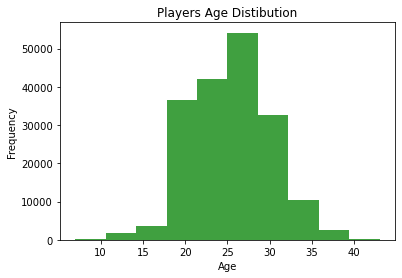

In [179]:
title = "Players Age Distibution"
xlabel = 'Age'
ylabel = 'Frequency'
color = 'g'
plt.hist(df_players['age'], facecolor=color, alpha=0.75)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title);

In [180]:
u18_players = df_players[df_players['age'] < 18]
u18_players[u18_players['overall_rating'] == u18_players['overall_rating'].max()]['player_name']

181772    Yevheniy Konoplyanka
Name: player_name, dtype: object

- Best u18 player was Yevheniy Konoplyanka

In [181]:
u18_players[u18_players['overall_rating'] == u18_players['overall_rating'].max()][['overall_rating', 'date', 'age']]

,overall_rating,date,age
181772,82.0,2007-02-22,17


- And his rating in 2007 was 82 when he was only 17 years old

### what is the average BMI of a soccer player in the period?

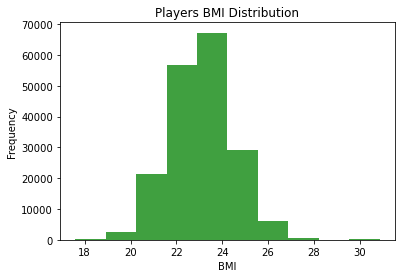

In [190]:
title = "Players BMI Distribution"
xlabel = 'BMI'
ylabel = 'Frequency'
color = 'g'
plt.hist(df_players['bmi'], facecolor=color, alpha=0.75)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title);

In [183]:
df_players['bmi'].mean()

23.1174116087206

- Average BMI of soccer players in this period was 23.12

### who was the tallest player played in this period?

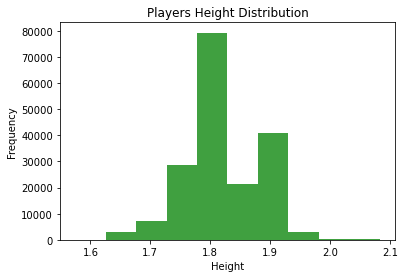

In [189]:
title = "Players Height Distribution"
xlabel = 'Height'
ylabel = 'Frequency'
color = 'g'
plt.hist(df_players['height_m'], facecolor=color, alpha=0.75)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title);

In [185]:
# player name
df_players[df_players['height_m'] == df_players['height_m'].max()].drop_duplicates(subset='player_name')['player_name']

98021    Kristof van Hout
Name: player_name, dtype: object

In [186]:
# player tall
df_players[df_players['height_m'] == df_players['height_m'].max()].drop_duplicates(subset='player_name')['height_m']

98021    2.0828
Name: height_m, dtype: float64

- The tallest player was Kristof van Hout with 2.08m tall

### who is the player who had the most penalties?

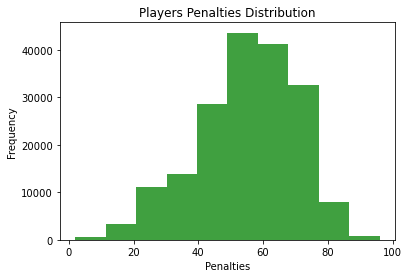

In [191]:
title = "Players Penalties Distribution"
xlabel = 'Penalties'
ylabel = 'Frequency'
color = 'g'
plt.hist(df_players['penalties'], facecolor=color, alpha=0.75)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title);

In [192]:
# player name
df_players[df_players['penalties'] == df_players['penalties'].max()].drop_duplicates(subset='player_name')['player_name']

149591    Rickie Lambert
Name: player_name, dtype: object

In [193]:
# number of penalties
df_players[df_players['penalties'] == df_players['penalties'].max()].drop_duplicates(subset='player_name')['penalties']

149591    96.0
Name: penalties, dtype: float64

- Rickie Lambert had the most penalties with 96 penalty

### What is the relationship between the player's age and his aggression level?

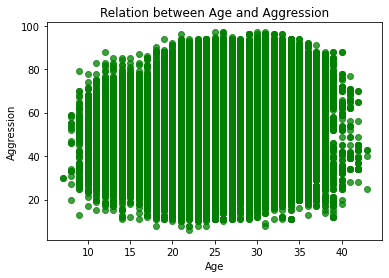

In [194]:
title = 'Relation between Age and Aggression'
xlabel = 'Age'
ylabel = 'Aggression'
color = 'g'
plt.scatter(df_players['age'], df_players['aggression'], facecolor=color, alpha=0.75);
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel);

- No relationship found between age and aggression

### what is the relationship between player's age and his finishing?

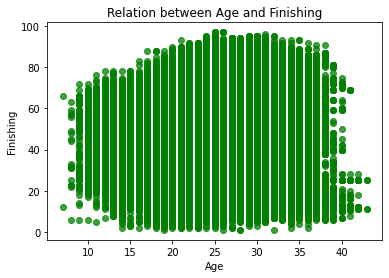

In [195]:
title = 'Relation between Age and Finishing'
xlabel = 'Age'
ylabel = 'Finishing'
color = 'g'
plt.scatter(df_players['age'], df_players['finishing'], facecolor=color, alpha=0.75);
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel);

- No relationship found between age and finishing

### What is the relationship between player's BMI(mass(KG)/height^2(M^2)) and shot power?

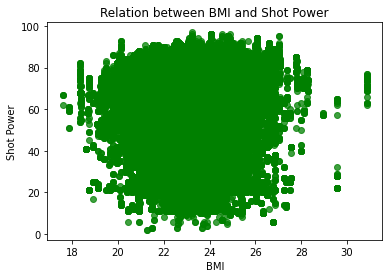

In [196]:
title = 'Relation between BMI and Shot Power'
xlabel = 'BMI'
ylabel = 'Shot Power'
color = 'g'
plt.scatter(df_players['bmi'], df_players['shot_power'], facecolor=color, alpha=0.75);
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel);

- No relationship found between bmi and shot power

### Broad Exploration for the dataset for interesting insights 

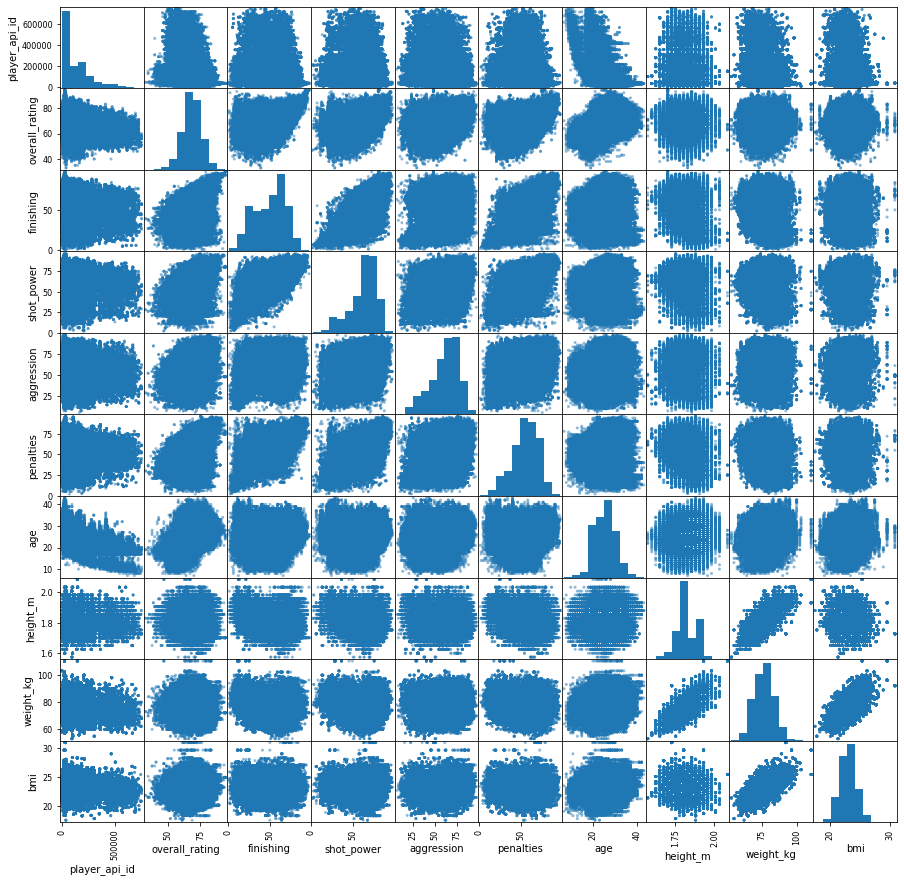

In [197]:
pd.plotting.scatter_matrix(df_players, figsize=(15, 15));

- seems like there is a positive relation between age and overall rating. Let's explore it!

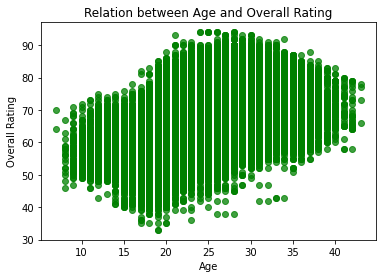

In [198]:
title = 'Relation between Age and Overall Rating'
xlabel = 'Age'
ylabel = 'Overall Rating'
color = 'g'
plt.scatter(df_players['age'], df_players['overall_rating'], facecolor=color, alpha=0.75);
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel);

- There is a positive relation between player's age and his overall rating

<a id='conclusions'></a>
## Conclusions


> Limitations:
> 
>> The dataset in hand contains data for players between seasons **2008** and **2016** and only for **EU players**.
>> 
>>
>> Results from **bivariate analysis** may slightly change with different datasets in different seasons.
>
> The above analysis for the dataset reveals that:
>
>> Best u18 player in this period was **Yevheniy Konoplyanka** whose rating (based on the overall_rating) in **2007** was **82** when he was only **17** years old
>>
>> average bmi = **23.12**
>>
>> tallest player between 2008 and 2016 is the **2.08m** Belgian goalkeeper **Kristof van Hout**.
>>
>> The English striker **Rickie Lambert** had the heighst number of penalties with **96** penalty.
>>  
>> There is **no relation** between player's **age** and player's **aggression**.
>>
>> There is **no relation** between player's **age** and his **finishing**. 
>>
>> There is **no relation** between player's **BMI** and his **shot power**.
>>
>> In the **EDA**, a **positive relation** between **age** and **overall rating** was found.

